We will do Topic modeling using two approaches:

* Latent Semantic Analysis of 20 news groups
* Latent Dirichlet Allocation of 20 news groups

dataset also avalaible here: https://archive.ics.uci.edu/dataset/113/twenty+newsgroups

In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import keras

from sklearn.datasets import fetch_20newsgroups
from tqdm import tqdm

import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from gensim.models import LdaModel
from gensim.corpora import Dictionary

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Read Data
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'),
                          random_state = 42, shuffle = True)

In [3]:
 # Keys
print(data.keys())

# Targets
print(data.target_names)

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [ ]:
# Data
data.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [4]:
# Display column width -> 150
pd.set_option("display.max_colwidth", 150)

In [23]:
# Lets create dataframe for better visualisation
texts = data.data
targets = data.target
d = {'texts':texts, 'targets':targets}
df = pd.DataFrame(d)
df

,texts,targets
0,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60...",7
1,A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message deta...,4
2,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nne...",4
3,\nDo you have Weitek's address/phone number? I'd like to get some information\nabout this chip.\n,1
4,"From article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n\n\nMy understanding is that the 'expected errors' are basicall...",14
...,...,...
11309,"DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nDN> A neurology\nDN> consultation is cheaper than a scan.\n\nAnd also better, because a neurologist c...",13
11310,"I have a (very old) Mac 512k and a Mac Plus, both of which \nhave the same problem.\n\nTheir screens blank out, sometimes after a minor physical j...",4
11311,"I just installed a DX2-66 CPU in a clone motherboard, and tried mounting a CPU \ncooler on the chip. After about 1/2 hour, the weight of the cool...",3
11312,"\nWouldn't this require a hyper-sphere. In 3-space, 4 points over specifies\na sphere as far as I can see. Unless that is you can prove that a p...",1


## Preprocessing

In [6]:
tqdm.pandas()

In [7]:
# Defining preprocess function
def preprocess(data):

  # lower case
  data = data.lower()

  #remove everything except alphabet
  data = re.sub(r'[^a-zA-Z#]', ' ', data)

  # punctuation removal
  data = data.translate(str.maketrans('','',string.punctuation))

  #remove numeric
  data = re.sub(r'\d+', '', data)

  # remove short words
  data = ' '.join([word for word in data.split() if len(word) > 3])

  # tokens
  words = word_tokenize(data)

  #lemming
  lemm = WordNetLemmatizer()
  data = [lemm.lemmatize(word) for word in words]
  preprocessed_data = ' '.join(data)

  return preprocessed_data

In [24]:
# Applying function
df['texts'] = df['texts'].progress_apply(preprocess)

100%|██████████| 11314/11314 [00:28<00:00, 400.12it/s]


In [25]:
df.head()

,texts,targets
0,wondering anyone there could enlighten this other door sport looked from late early called bricklin door were really small addition front bumper s...,7
1,fair number brave soul upgraded their clock oscillator have shared their experience this poll please send brief message detailing your experience ...,4
2,well folk plus finally gave ghost this weekend after starting life back sooo market machine sooner than intended looking into picking powerbook ma...,4
3,have weitek address phone number like some information about this chip,1
4,from article owcb world tombaker world baker understanding that expected error basically known bug warning system software thing checked that have...,14


## Document-term Matrix

I will use TF-IDF vectorizer

In [10]:
# Defining tf-idf cevtorizer with max_features = all
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(df['texts'])
print(X_tfidf.shape)

(11314, 59267)


In [11]:
# Lets see which features we have
print(vectorizer.get_feature_names_out()[100:200])

['abide' 'abides' 'abideth' 'abiding' 'abig' 'abilene' 'ability' 'abiliy'
 'abingdon' 'abington' 'abiogenesis' 'abjuring' 'abkect' 'abkhazia'
 'ablazing' 'able' 'ablility' 'ably' 'abner' 'abnormal' 'abnormality'
 'abnormally' 'abnt' 'aboard' 'aboce' 'abode' 'aboid' 'abolish'
 'abolished' 'abolishing' 'abolishment' 'abolition' 'abolitionist' 'abomb'
 'abominable' 'abomination' 'abord' 'abort' 'aborted' 'abortion' 'abotu'
 'abou' 'abound' 'abounded' 'abounds' 'abovementioned' 'abph' 'abput'
 'abraam' 'abraham' 'abrahamic' 'abram' 'abramyan' 'abrasion' 'abrasive'
 'abreast' 'abri' 'abridge' 'abridged' 'abridgement' 'abridging'
 'abridgment' 'abroad' 'abrogation' 'abrupt' 'abruptly' 'abscence'
 'abscess' 'absence' 'absense' 'absent' 'absentee' 'absol' 'absolut'
 'absolute' 'absolutely' 'absolutey' 'absolutism' 'absolutist' 'absolve'
 'absolving' 'absood' 'absorb' 'absorbed' 'absorber' 'absorbing' 'absorbs'
 'absorbtion' 'absorption' 'absoultly' 'abstact' 'abstacted' 'abstain'
 'abstinence'

# Topic Modeling

# Latent Semantic Analysis (LSA)

On some assumption, I will choose 20 topics, because it is about 20 newsgroups

In [ ]:
# Number of topics
k = 20

# define svd model
svd = TruncatedSVD(n_components=k, random_state = 42,
                   algorithm = 'randomized', n_iter=100)
#fit
svd.fit(X_tfidf)

TruncatedSVD(n_components=20, n_iter=100, random_state=42)

In [ ]:
svd.components_.shape

(20, 59267)

In [ ]:
# Document topics
X_svd = svd.fit_transform(X_tfidf)
print('Shape:', X_svd.shape)

Shape: (11314, 20)


In [ ]:
# Features/words/terms
terms = vectorizer.get_feature_names_out()

# Lets see the topics
for i, vec in enumerate(svd.components_):
  sorted_indices_svd = np.argsort(vec)[::-1] #descending order
  topic_words_svd = np.array(terms)[sorted_indices_svd]
  topic_words_svd = topic_words_svd[:10] # only top 10
  # print(topic_words_svd)
  # break
  print('Topic', i+1, topic_words_svd)


Topic 1 ['know' 'like' 'just' 'people' 'think' 'window' 'time' 'problem' 'good'
 'thanks']
Topic 2 ['window' 'drive' 'file' 'card' 'thanks' 'driver' 'disk' 'program' 'scsi'
 'color']
Topic 3 ['drive' 'scsi' 'disk' 'hard' 'controller' 'floppy' 'card' 'game' 'cable'
 'offer']
Topic 4 ['game' 'team' 'player' 'year' 'season' 'play' 'hockey' 'league' 'playoff'
 'baseball']
Topic 5 ['card' 'chip' 'video' 'monitor' 'thanks' 'clipper' 'phone' 'encryption'
 'driver' 'mail']
Topic 6 ['card' 'driver' 'window' 'video' 'jesus' 'christian' 'monitor' 'problem'
 'color' 'think']
Topic 7 ['thanks' 'know' 'mail' 'advance' 'christian' 'jesus' 'looking' 'info'
 'email' 'post']
Topic 8 ['pitt' 'cadre' 'chastity' 'shameful' 'intellect' 'skepticism' 'surrender'
 'gordon' 'bank' 'soon']
Topic 9 ['file' 'card' 'game' 'armenian' 'video' 'format' 'christian' 'jesus'
 'driver' 'israel']
Topic 10 ['armenian' 'israel' 'thanks' 'israeli' 'turkish' 'arab' 'window' 'state'
 'people' 'right']
Topic 11 ['window' 'chip' 

### Wordcloud with LSA

In [ ]:
# First join all topics
topics = []
for i, vec in enumerate(svd.components_):
  sorted_indices_svd = np.argsort(vec)[::-1]
  topic_words_svd = np.array(terms)[sorted_indices_svd][:10]
  topic_words_svd = ' '.join(topic_words_svd)
  topics.append(topic_words_svd)

In [ ]:
topics

['know like just people think window time problem good thanks',
 'window drive file card thanks driver disk program scsi color',
 'drive scsi disk hard controller floppy card game cable offer',
 'game team player year season play hockey league playoff baseball',
 'card chip video monitor thanks clipper phone encryption driver mail',
 'card driver window video jesus christian monitor problem color think',
 'thanks know mail advance christian jesus looking info email post',
 'pitt cadre chastity shameful intellect skepticism surrender gordon bank soon',
 'file card game armenian video format christian jesus driver israel',
 'armenian israel thanks israeli turkish arab window state people right',
 'window chip game thanks drive encryption christian jesus clipper scsi',
 'know just thanks driver file chip right scsi like encryption',
 'problem space scsi program server using time team nasa image',
 'armenian chip turkish jesus problem armenia genocide turk turkey azeri',
 'driver space scs

In [ ]:
# Document
for i in range(k):
  topic_doc = X_svd[i].argmax()
  print('Document', i , ' ---- Topic ',topic_doc )

Document 0  ---- Topic  0
Document 1  ---- Topic  0
Document 2  ---- Topic  0
Document 3  ---- Topic  0
Document 4  ---- Topic  0
Document 5  ---- Topic  0
Document 6  ---- Topic  6
Document 7  ---- Topic  17
Document 8  ---- Topic  0
Document 9  ---- Topic  0
Document 10  ---- Topic  19
Document 11  ---- Topic  0
Document 12  ---- Topic  0
Document 13  ---- Topic  0
Document 14  ---- Topic  0
Document 15  ---- Topic  0
Document 16  ---- Topic  0
Document 17  ---- Topic  0
Document 18  ---- Topic  0
Document 19  ---- Topic  0


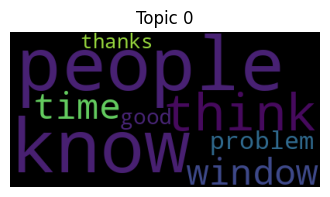

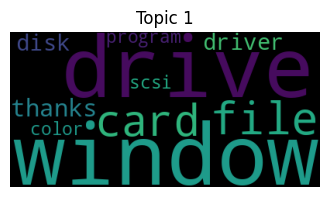

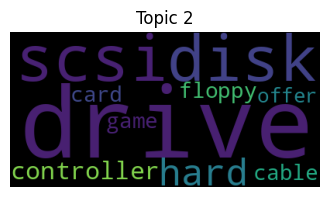

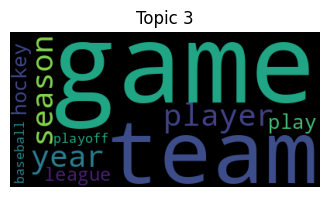

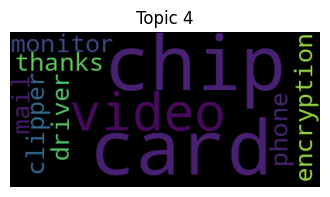

In [ ]:
# Visualisation of first 5
for i in range(5):
  plt.figure(figsize = (4,4))
  wc = WordCloud(random_state = 42).generate(topics[i])
  plt.imshow(wc)
  plt.title(f'Topic {i}')
  plt.axis('off')
  plt.show()

# Latent Dirichlet Allocation

LDA can be done by using gensim models LdaModel, or can be done with sklearn library by using decomposition.LatentDirichletAllocation

In [ ]:
# We are going to use sklearn LDA
lda = LatentDirichletAllocation(n_components = k,random_state = 42,
                                max_iter = 100)
lda.fit(X_tfidf)

LatentDirichletAllocation(max_iter=100, n_components=20, random_state=42)

In [ ]:
lda.components_.shape

(20, 58879)

In [ ]:
# Document topics
X_lda = lda.fit_transform(X_tfidf)
print('Shape:', X_lda.shape)

In [ ]:
# We already create vocabulary -> term
for i, v in enumerate(lda.components_):
  lda_indices = np.argsort(v)[::-1]
  sorted_lda_words = np.array(terms)[lda_indices][:10]
  print('Topic', i+1, sorted_lda_words)

Topic 1 ['randy' 'shack' 'kidding' 'transformer' 'uiuc' 'whaler' 'christopher'
 'passion' 'liturgy' 'josh']
Topic 2 ['satan' 'nist' 'freewill' 'angel' 'mcguire' 'ncsl' 'csrc' 'breathing'
 'daigle' 'ncsa']
Topic 3 ['tiff' 'chop' 'garrett' 'panicking' 'deletion' 'kernel' 'athena' 'lyme'
 'solaris' 'decoration']
Topic 4 ['winner' 'arafat' 'ansi' 'tektronix' 'underdog' 'bored' 'devguide'
 'survivor' 'harry' 'nutek']
Topic 5 ['pixmap' 'dubinski' 'baden' 'recorder' 'squid' 'callback' 'latch'
 'adaptor' 'dividians' 'iivx']
Topic 6 ['know' 'like' 'just' 'people' 'think' 'time' 'thanks' 'window' 'good'
 'problem']
Topic 7 ['manhattan' 'bobbe' 'bronx' 'beauchaine' 'sank' 'blew' 'queen' 'hillary'
 'cheat' 'sail']
Topic 8 ['ottoman' 'henrik' 'mary' 'tartar' 'suck' 'mydisplay' 'music' 'nords'
 'buggy' 'conception']
Topic 9 ['pitching' 'easter' 'clemens' 'mpeg' 'zeos' 'bait' 'salvation' 'gainey'
 'dayton' 'train']
Topic 10 ['exhaust' 'azerbaijani' 'russia' 'valve' 'newest' 'loan' 'carbs'
 'founded' 

In [ ]:
# Which topic belongs to which document
for i in range(20):
  topic_doc = X_lda[i].argmax()
  print('Document', i+1 , ' ---- Topic ',topic_doc )

Document 1  ---- Topic  3
Document 2  ---- Topic  3
Document 3  ---- Topic  3
Document 4  ---- Topic  8
Document 5  ---- Topic  3
Document 6  ---- Topic  3
Document 7  ---- Topic  3
Document 8  ---- Topic  3
Document 9  ---- Topic  7
Document 10  ---- Topic  3
Document 11  ---- Topic  3
Document 12  ---- Topic  3
Document 13  ---- Topic  0
Document 14  ---- Topic  3
Document 15  ---- Topic  3
Document 16  ---- Topic  3
Document 17  ---- Topic  3
Document 18  ---- Topic  3
Document 19  ---- Topic  3
Document 20  ---- Topic  3


### Wordcloud for LDA

In [ ]:
# All topics together
topics_lda = []

for i, v in enumerate(lda.components_):
  lda_indices = np.argsort(v)[::-1]
  sorted_lda_words = np.array(terms)[lda_indices][:10]
  sorted_lda_words = ' '.join(sorted_lda_words)
  topics_lda.append(sorted_lda_words)

In [ ]:
topics_lda

['randy shack kidding transformer uiuc whaler christopher passion liturgy josh',
 'satan nist freewill angel mcguire ncsl csrc breathing daigle ncsa',
 'tiff chop garrett panicking deletion kernel athena lyme solaris decoration',
 'winner arafat ansi tektronix underdog bored devguide survivor harry nutek',
 'pixmap dubinski baden recorder squid callback latch adaptor dividians iivx',
 'know like just people think time thanks window good problem',
 'manhattan bobbe bronx beauchaine sank blew queen hillary cheat sail',
 'ottoman henrik mary tartar suck mydisplay music nords buggy conception',
 'pitching easter clemens mpeg zeos bait salvation gainey dayton train',
 'exhaust azerbaijani russia valve newest loan carbs founded handlebar sumgait',
 'chicago detroit tank devil islander plane armenia vancouver winning handgun',
 'digital absolute heat cryptography analysis status doctrine lebanese prevent identical',
 'upenn champ kkeller quaker keller ctrl blah weaver subscribe searching',
 '

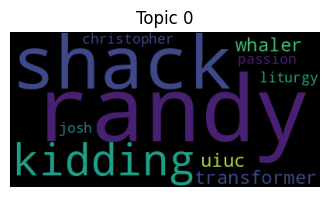

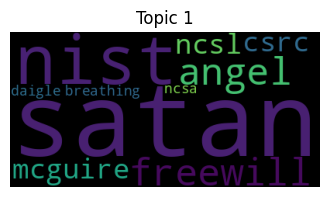

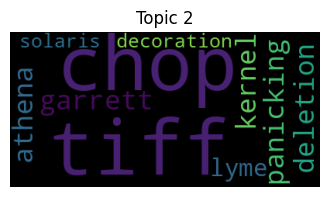

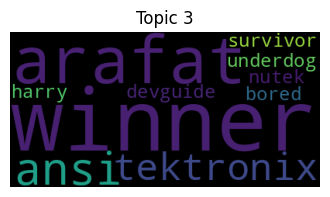

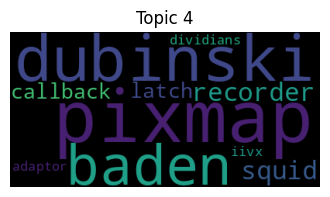

In [ ]:
# Visualisation of first 5
for i in range(5):
  plt.figure(figsize = (4,4))
  wc2 = WordCloud(random_state = 42).generate(topics_lda[i])
  plt.imshow(wc2)
  plt.title(f'Topic {i}')
  plt.axis('off')
  plt.show()

##### LDA with gensim

In [26]:
# step1: Tokenize data and remove stopwords
df['texts'] = [word_tokenize(words) for words in df['texts']]

# Define stop words
stop_words = stopwords.words('english')

df['texts'] = df['texts'].progress_apply(lambda words: [word for word in words if word not in stop_words])

100%|██████████| 11314/11314 [00:05<00:00, 2037.11it/s]


In [27]:
df.head()

,texts,targets
0,"[wondering, anyone, could, enlighten, door, sport, looked, late, early, called, bricklin, door, really, small, addition, front, bumper, separate, ...",7
1,"[fair, number, brave, soul, upgraded, clock, oscillator, shared, experience, poll, please, send, brief, message, detailing, experience, procedure,...",4
2,"[well, folk, plus, finally, gave, ghost, weekend, starting, life, back, sooo, market, machine, sooner, intended, looking, picking, powerbook, mayb...",4
3,"[weitek, address, phone, number, like, information, chip]",1
4,"[article, owcb, world, tombaker, world, baker, understanding, expected, error, basically, known, bug, warning, system, software, thing, checked, r...",14


In [33]:
# Step2: build dictionary and corpus of preprocessed text
dictionary = Dictionary(df['texts'])

# Filter tokens
dictionary.filter_extremes(no_below = 5, no_above=0.5)

# Build corpus
corpus = [dictionary.doc2bow(text) for text in df['texts']] # creates list of tuples(token index, token count)

In [38]:
# Step 3: Build the model
lda_model = LdaModel(corpus = corpus, num_topics = 20,
                     id2word = dictionary,random_state=42, passes = 50) #id2word converts tokens id to their corresponding word

In [45]:
# Step 4: Topics discovery
topics_lda_model = lda_model.show_topics(num_topics = 20,
                                         num_words=10,
                                         formatted = False)

# Lets print number of topic and top 10 words with their probabilities of each word occurring in the given topic
for topic_id, topics in topics_lda_model:
  print('Topic:', topic_id)
  for t in topics:
    print(t)

Topic: 0
('window', 0.022265231)
('file', 0.019295016)
('image', 0.01757349)
('program', 0.014357222)
('version', 0.014268549)
('available', 0.013082)
('server', 0.012163411)
('graphic', 0.011199923)
('software', 0.011193736)
('color', 0.009691523)
Topic: 1
('card', 0.020690382)
('price', 0.015642015)
('chip', 0.013184454)
('monitor', 0.012810961)
('scsi', 0.011971996)
('video', 0.011415467)
('sale', 0.01043612)
('offer', 0.009680606)
('used', 0.009328296)
('speed', 0.00896848)
Topic: 2
('value', 0.02472052)
('code', 0.019472396)
('event', 0.015204213)
('line', 0.014526566)
('application', 0.01442463)
('widget', 0.014089959)
('function', 0.012729124)
('call', 0.012293783)
('point', 0.010500848)
('problem', 0.010257328)
Topic: 3
('state', 0.015413172)
('government', 0.013143282)
('people', 0.012044804)
('right', 0.011952066)
('weapon', 0.009281863)
('turkish', 0.008743852)
('crime', 0.008561584)
('armenian', 0.008480762)
('firearm', 0.007401362)
('american', 0.0072002024)
Topic: 4
('pre

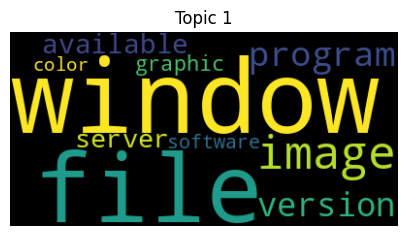

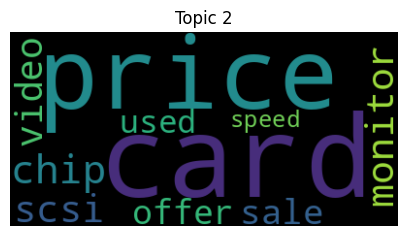

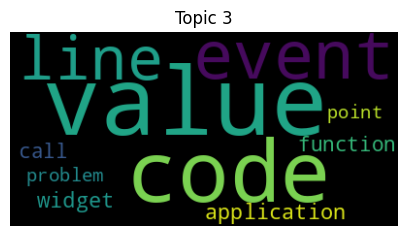

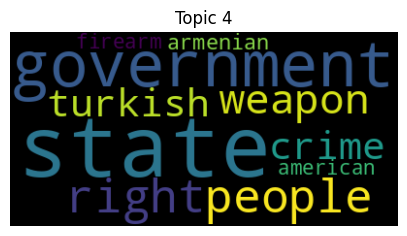

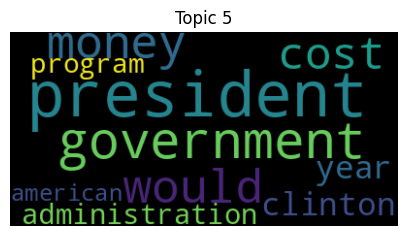

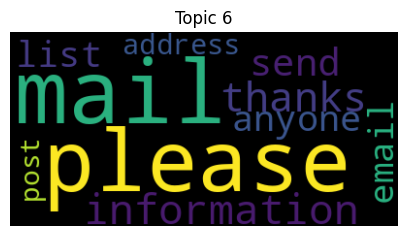

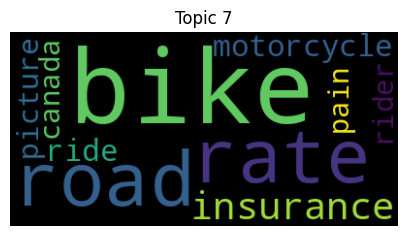

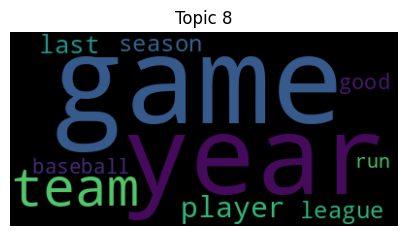

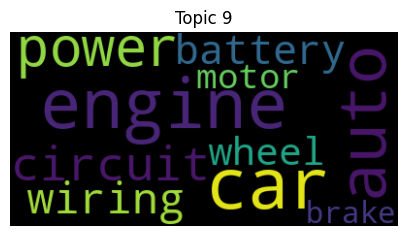

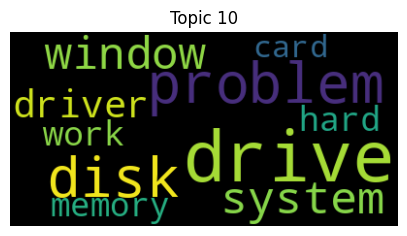

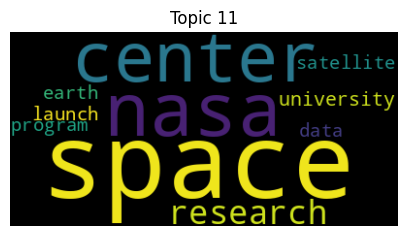

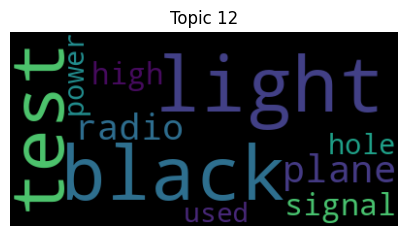

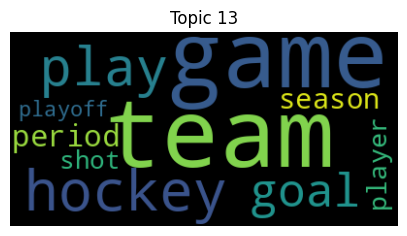

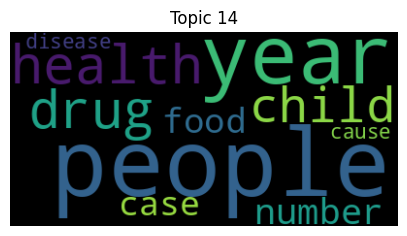

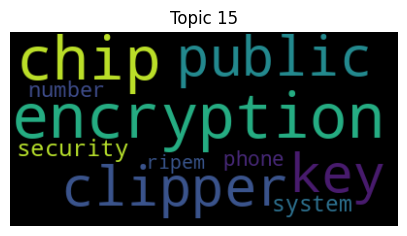

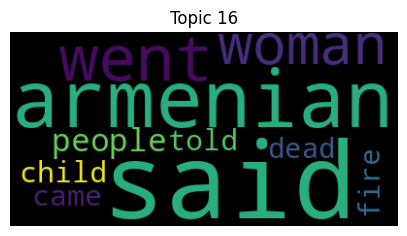

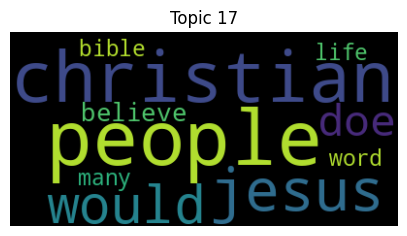

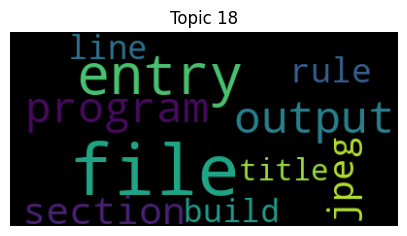

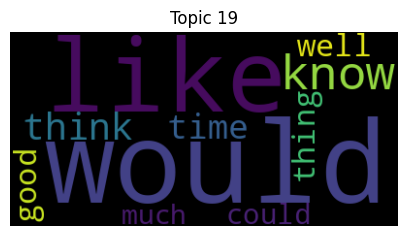

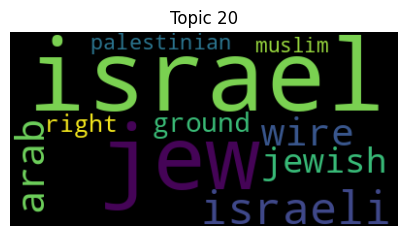

In [53]:
# Create wordcloud
for topic_id, topic in topics_lda_model:
    word_freq = {word: prob for word, prob in topic}
    wordcloud = WordCloud().generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Topic {}'.format(topic_id + 1))
    plt.axis('off')
    plt.show()